In [2]:
import os
import numpy as np
import pandas as pd
import sklearn as skl
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [16]:
from sklearn.feature_selection import mutual_info_classif
from tqdm import tqdm 

In [4]:
datapath = os.path.join('data', 'US', 'us_data_weekly.csv')
dus_weekly = pd.read_csv(datapath, index_col=0)
dus_weekly = dus_weekly.dropna()

In [5]:
dus_weekly

,RPI,INDPRO,UNRATE,UEMP5TO14,PAYEMS,USGOOD,USCONS,MANEMP,DMANEMP,NDMANEMP,...,DCOILWTICO,FEDFUNDS,CURRCIR,BOGMBASE,WSHOSHO,WSHOTSL,T5YIE,T10YIE,log return gold,log return sp500
2003-01-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.051515,0.000000,0.000000,0.000000,0.000000,0.000000,0.12,0.13,0.009860,0.020674
2003-01-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.069984,0.000000,0.000000,0.000000,0.000000,0.000000,0.05,0.05,0.005062,-0.028198
2003-01-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.031952,0.000000,0.000000,0.000000,0.000000,0.000000,0.01,0.00,0.033488,-0.045812
2003-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.042933,0.000000,0.000000,0.000000,0.000000,0.000000,0.03,0.01,-0.000380,-0.006639
2003-02-07,-0.003545,0.001246,0.017094,0.011169,-0.001011,-0.005615,-0.005534,-0.005869,-0.006874,-0.004242,...,0.044932,0.016000,0.000619,0.002428,-0.000008,-0.000008,0.11,0.08,0.003846,-0.030868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-06,0.001065,0.010677,-0.024098,-0.032515,0.002034,0.000185,0.001811,-0.000783,-0.001895,0.001031,...,0.004677,-0.035091,0.001086,-0.002210,-0.001155,-0.001757,-0.02,-0.02,-0.007809,0.009551
2024-12-13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.042256,0.000000,0.000000,0.000000,0.000018,0.000028,0.09,0.09,0.005862,-0.006454
2024-12-20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.025913,0.000000,0.000000,0.000000,-0.001087,-0.001610,-0.06,-0.04,-0.010484,-0.020071
2024-12-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.022272,0.000000,0.000000,0.000000,-0.000479,0.000039,0.04,0.05,-0.000294,0.006720


In [6]:
def add_ts_features(df, cols, max_lag=20, windows=[10,20,50]):

    all_features = {}

    for col in cols:
        y = df[col]

        # --- Rolling statistics ---
        for w in windows:
            roll = y.rolling(w)
            all_features[f'{col}_mean_{w}'] = roll.mean()
            all_features[f'{col}_std_{w}'] = roll.std()
            all_features[f'{col}_q25_{w}'] = roll.quantile(0.25)
            all_features[f'{col}_q75_{w}'] = roll.quantile(0.75)
            all_features[f'{col}_q05_{w}'] = roll.quantile(0.05)
            all_features[f'{col}_q90_{w}'] = roll.quantile(0.9)
            all_features[f'{col}_range_{w}'] = roll.max() - roll.min()

            # Z-score et momentum
            all_features[f'{col}_zscore_{w}'] = (y - roll.mean()) / roll.std()
            all_features[f'{col}_momentum_{w}'] = y - y.shift(w)

        # Ratio de moyennes rapides / lentes
        all_features[f'{col}_ratio_{10}_{50}'] = (
            y.rolling(10).mean() / y.rolling(50).mean()
        )

        # Volatilité annualisée approx
        all_features[f'{col}_vol_20'] = y.rolling(20).std() * np.sqrt(52)

        # --- Lags bruts ---
        for lag in [1,2,3,4,5,10,15,20,25,30,40,50]:
            all_features[f'{col}_lag_{lag}'] = y.shift(lag-1)

        # --- Autocorrélations (in-sample) ---
        
        acf_vals = acf(y.dropna(), nlags=max_lag, fft=True)
        for lag in range(1, max_lag + 1):
            all_features[f'{col}_autocorr_{lag}'] = acf_vals[lag]

    # --- Construction finale ---
    features = pd.DataFrame(all_features, index=df.index)
    return features

In [7]:
cols = ['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3',
        'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']
dus_features = add_ts_features(dus_weekly, cols)
dus_features= dus_features.dropna()
dus_weekly = dus_weekly.merge(dus_features, how = 'inner', left_index=True, right_index=True)
for col in cols: 
        dus_weekly[f'Y_{col}'] = (dus_weekly[col]>0).astype(int).shift(-1)
dus_weekly = dus_weekly.drop(columns=cols)
dus_weekly= dus_weekly.dropna()

In [8]:
dus_weekly = dus_weekly.replace([np.inf, -np.inf], np.nan)
dus_weekly.ffill()
dus_weekly

,RPI,INDPRO,UNRATE,UEMP5TO14,PAYEMS,USGOOD,USCONS,MANEMP,DMANEMP,NDMANEMP,...,Y_DGS3MO,Y_DGS6MO,Y_DGS1,Y_DGS2,Y_DGS3,Y_DGS5,Y_DGS7,Y_DGS10,Y_DGS20,Y_DGS30
2003-12-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2004-01-02,-0.001943,0.001665,0.000000,-0.035659,0.001278,0.000599,0.003071,-0.000560,0.000790,-0.002760,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2004-01-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2004-01-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2004-01-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-12-06,0.001065,0.010677,-0.024098,-0.032515,0.002034,0.000185,0.001811,-0.000783,-0.001895,0.001031,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2024-12-13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2024-12-20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [9]:
Yw = dus_weekly[[f'Y_{col}' for col in cols]]
Xw = dus_weekly.drop(columns = [f'Y_{col}' for col in cols]).ffill()

In [10]:
selected_features_w = set()
for col in tqdm(Yw.columns):
    mi = mutual_info_classif(Xw, Yw[col])
    top_features_i = Xw.columns[mi > 0.03]  
    selected_features_w.update(top_features_i)
print('we removed',Xw.shape[1]-len(selected_features_w), 'features in the weekly dataset')

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:09<00:00,  1.17it/s]

we removed 465 features in the weekly dataset


In [11]:
Xw = Xw[list(selected_features_w)]
Xw

,DGS6MO_autocorr_7,DGS7_range_50,DGS20_autocorr_17,DGS30_q25_50,DGS6MO_autocorr_17,DGS5_autocorr_10,DGS30_q90_10,DGS2_q05_20,T5YIE,DGS20_q90_20,...,DGS1MO_q05_50,DGS3MO_q75_20,DGS6MO_mean_10,DGS10_q25_20,DGS5_std_50,DGS2_q25_10,DGS10_lag_40,DGS3MO_autocorr_3,FGEXPND,DGS30_autocorr_10
2003-12-26,0.137187,0.69,0.045528,-0.0875,0.092776,-0.017815,0.100,-0.2015,0.03,0.152,...,-0.1010,0.0000,-0.003,-0.1025,0.169999,-0.1150,-0.19,0.142966,0.000000,-0.050217
2004-01-02,0.137187,0.69,0.045528,-0.0800,0.092776,-0.017815,0.105,-0.2015,0.07,0.152,...,-0.1010,0.0025,-0.001,-0.1025,0.170700,-0.0350,0.04,0.142966,0.015602,-0.050217
2004-01-09,0.137187,0.72,0.045528,-0.0875,0.092776,-0.017815,0.105,-0.2315,-0.15,0.152,...,-0.1010,0.0000,-0.007,-0.1100,0.175610,-0.1450,0.04,0.142966,0.000000,-0.050217
2004-01-16,0.137187,0.72,0.045528,-0.0975,0.092776,-0.017815,0.105,-0.2315,0.08,0.152,...,-0.1010,0.0025,-0.010,-0.1100,0.175179,-0.1450,-0.02,0.142966,0.000000,-0.050217
2004-01-23,0.137187,0.72,0.045528,-0.0975,0.092776,-0.017815,0.105,-0.2030,0.04,0.152,...,-0.1010,0.0100,-0.008,-0.1100,0.175077,-0.0350,-0.07,0.142966,0.000000,-0.050217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-29,0.137187,0.70,0.045528,-0.0650,0.092776,-0.017815,0.133,-0.2615,-0.10,0.140,...,-0.1300,0.0000,-0.001,-0.0625,0.146413,0.0050,-0.07,0.142966,0.000000,-0.050217
2024-12-06,0.137187,0.70,0.045528,-0.0650,0.092776,-0.017815,0.133,-0.2615,-0.02,0.140,...,-0.1355,0.0000,-0.001,-0.0625,0.146321,0.0050,-0.10,0.142966,0.000000,-0.050217
2024-12-13,0.137187,0.70,0.045528,-0.0650,0.092776,-0.017815,0.144,-0.2615,0.09,0.144,...,-0.1400,0.0000,-0.013,-0.0625,0.149403,0.0050,0.22,0.142966,0.000000,-0.050217
2024-12-20,0.137187,0.70,0.045528,-0.0650,0.092776,-0.017815,0.144,-0.2405,-0.06,0.144,...,-0.1400,0.0000,-0.015,-0.0525,0.148231,0.0125,-0.09,0.142966,0.000000,-0.050217


In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import copy # For saving the best model state

In [20]:
# --- 1. Helper Function: Create Sequences ---

def create_sequences(features, targets, lookback_weeks, forecast_horizon):
    """
    Transforms time-series data into sequences for LSTM.
    
    Args:
        features (np.array): Standardized features.
        targets (np.array): Binary targets (n_samples, n_maturities).
        lookback_weeks (int): How many weeks of history to use (L).
        forecast_horizon (int): How many weeks ahead to predict (4).
        
    Returns:
        X (np.array): Input sequences, shape (samples, lookback, n_features)
        y (np.array): Target sequences, shape (samples, forecast_horizon, n_maturities)
    """
    X, y = [], []
    n_samples = len(features)
    
    for i in range(n_samples):
        # Find the end of this sequence
        feature_end = i + lookback_weeks
        target_end = feature_end + forecast_horizon
        
        # Stop if we are at the end of the dataset
        if target_end > n_samples:
            break
            
        # Get input (history) and output (future)
        seq_x = features[i:feature_end, :]
        seq_y = targets[feature_end:target_end, :] # Shape (4, M)
        
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)

In [71]:
class LSTMClassifier(nn.Module):
    """
    PyTorch-based LSTM Classifier for multi-step, multi-output forecasting.
    """
    def __init__(self, n_features, n_maturities, forecast_horizon=4, 
                lstm_hidden_1=32, lstm_hidden_2=16, dense_hidden=32):
        
        super(LSTMClassifier, self).__init__()
        
        self.forecast_horizon = forecast_horizon
        self.n_maturities = n_maturities
        
        # --- Define Layers ---
        
        # batch_first=True makes the input shape (batch_size, seq_len, features)
        self.lstm1 = nn.LSTM(
            input_size=n_features, 
            hidden_size=lstm_hidden_1, 
            num_layers=1, 
            batch_first=True
        )
        self.dropout1 = nn.Dropout(0.3)
        
        self.lstm2 = nn.LSTM(
            input_size=lstm_hidden_1, 
            hidden_size=lstm_hidden_2, 
            num_layers=1, 
            batch_first=True
        )
        self.dropout2 = nn.Dropout(0.3)
        
        self.dense1 = nn.Linear(lstm_hidden_2, dense_hidden)
        self.relu = nn.ReLU()
        
        self.output_layer = nn.Linear(dense_hidden, forecast_horizon * n_maturities)
        
        # We apply sigmoid in the forward pass for nn.BCELoss
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        """Defines the forward pass of the model."""
        
        # x shape: (batch_size, lookback_weeks, n_features)
        
        # lstm1 output (output, (h_n, c_n))
        lstm_out1, _ = self.lstm1(x) 
        lstm_out1 = self.dropout1(lstm_out1)
        
        # lstm2 output
        lstm_out2, _ = self.lstm2(lstm_out1) 
        
        # Get the last hidden state from the sequence
        # lstm_out2 shape is (batch_size, lookback_weeks, lstm_hidden_2)
        last_hidden_state = lstm_out2[:, -1, :] 
        last_hidden_state = self.dropout2(last_hidden_state)
        
        # Pass through dense layers
        dense_out = self.relu(self.dense1(last_hidden_state))
        
        # Get final flat output
        flat_output = self.output_layer(dense_out)
        
        # Apply sigmoid activation
        prob_output = self.sigmoid(flat_output)
        
        # Reshape to (batch_size, 4, M)
        final_output = prob_output.view(-1, self.forecast_horizon, self.n_maturities)
        
        return final_output

In [72]:
def train_model_torch(
    model, 
    X_train, y_train, 
    X_val, y_val, 
    device,
    epochs=50, 
    batch_size=32, 
    patience=5, 
    lr=0.001):
    """
    PyTorch training and validation loop with early stopping.
    """
    
    # 1. Create DataLoaders
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # 2. Define Loss and Optimizer
    # nn.BCELoss expects sigmoid output, which our model provides
    criterion = nn.BCELoss() 
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1.e-4)
    
    # 3. Early Stopping setup
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        # --- Training ---
        model.train() # Set model to training mode
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()       # Zero gradients
            outputs = model(inputs)     # Forward pass
            loss = criterion(outputs, targets) # Calculate loss
            loss.backward()             # Backward pass
            optimizer.step()            # Update weights
            
            train_loss += loss.item() * inputs.size(0)
        
        train_loss /= len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        # --- Validation ---
        model.eval() # Set model to evaluation mode
        val_loss = 0.0
        with torch.no_grad(): # Disable gradient calculation
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
        
        val_loss /= len(val_loader.dataset)
        history['val_loss'].append(val_loss)
        
        # --- Early Stopping Check ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model state
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            # print(f"Epoch {epoch+1}: Early stopping.") # Uncomment for debug
            break
    
    # Restore best model weights
    if best_model_state:
        model.load_state_dict(best_model_state)
        
    return model, history # Return the best (early-stopped) trained model

In [79]:
def run_rolling_forecast_torch(
    all_features_df, 
    all_targets_df, 
    n_maturities,
    lookback_weeks=52, 
    train_val_window_weeks=780, # 15 years * 52 weeks
    val_split_ratio=0.2,
    forecast_horizon=4,
    roll_step_weeks=4):
    """
    Conducts the full rolling-window forecast using PyTorch
    """
    
    print("Starting PyTorch rolling window forecast...")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    all_predictions = []
    
    last_fold_history = None
    
    val_weeks = int(train_val_window_weeks * val_split_ratio)
    train_weeks = train_val_window_weeks - val_weeks
    
    start_pred_idx = train_val_window_weeks
    
    for t in tqdm(range(start_pred_idx, len(all_features_df) - forecast_horizon + 1, roll_step_weeks)):
        
        # --- A. Define Window Indices ---
        pred_input_start = t - lookback_weeks
        pred_input_end = t
        
        val_end = pred_input_end
        # The full training/validation block starts here
        train_start = val_end - train_val_window_weeks 
        
        # The training-only block ends here
        train_end = val_end - val_weeks
        
        if train_start < 0:
            continue
            
        # --- B. Get Data Slices ---
        # Get the full 15-year block of features
        train_val_features_df = all_features_df.iloc[train_start:val_end]
        
        # Get the test lookback features
        test_lookback_features_df = all_features_df.iloc[pred_input_start:pred_input_end]

        # Get targets for the 15-year block *plus* the 4-week forecast horizon
        # This is needed by create_sequences
        train_val_targets_df = all_targets_df.iloc[train_start : val_end + forecast_horizon]

        # --- C. Standardize Features ---
        # 1. Isolate the *training-only* part for fitting the scaler
        train_only_features = train_val_features_df.iloc[:train_weeks]
        
        scaler = StandardScaler()
        # 2. Fit ONLY on training data
        scaler.fit(train_only_features.values)
        
        # 3. Transform *all* relevant feature blocks
        train_val_features_scaled = scaler.transform(train_val_features_df.values)
        test_lookback_features_scaled = scaler.transform(test_lookback_features_df.values)
        
        # --- D. Create Sequences  ---
        # Create sequences for the *entire* 15-year window at once.
        X_train_val_seq, y_train_val_seq = create_sequences(
            train_val_features_scaled, 
            train_val_targets_df.values, # Pass full targets
            lookback_weeks, 
            forecast_horizon
        )
        
        if len(X_train_val_seq) == 0:
            print(f"Skipping prediction for index {t}, not enough data to form sequences.")
            continue

        # --- E. Split Sequences Manually  ---
        # We need to find the *index* in the *sequence array* that 
        # corresponds to the end of the training data.
        
        # The last sequence whose *input data* is 100% from the training block
        # is the one starting at index (train_weeks - lookback_weeks).
        # Its *target* will be the first 4 weeks of the validation set.
        # This is a valid train/val split.
        
        # The split point is the *count* of training sequences.
        # The sequences are 0-indexed.
        # Sequences 0 through (train_weeks - lookback_weeks) are training.
        # Total training sequences = (train_weeks - lookback_weeks) + 1
        
        split_idx = train_weeks - lookback_weeks + 1

        # Check if the split index is valid
        if split_idx <= 0 or split_idx >= len(X_train_val_seq):
            print(f"Skipping index {t}: Invalid data split, not enough history for validation.")
            continue

        X_train = X_train_val_seq[:split_idx]
        y_train = y_train_val_seq[:split_idx]
        
        X_val = X_train_val_seq[split_idx:]
        y_val = y_train_val_seq[split_idx:]

        if len(X_train) == 0 or len(X_val) == 0:
            print(f"Skipping index {t}: Not enough data for train ({len(X_train)}) or val ({len(X_val)}).")
            continue
            
        # --- F. Convert to PyTorch Tensors ---
        X_train_tensor = torch.from_numpy(X_train).float().to(device)
        y_train_tensor = torch.from_numpy(y_train).float().to(device)
        X_val_tensor = torch.from_numpy(X_val).float().to(device)
        y_val_tensor = torch.from_numpy(y_val).float().to(device)
        
        # --- G. Build, Train, and Predict ---
        model = LSTMClassifier(
            n_features=all_features_df.shape[1], 
            n_maturities=n_maturities, 
            forecast_horizon=forecast_horizon
        ).to(device)
        
        model, history = train_model_torch(
            model,
            X_train_tensor, y_train_tensor,
            X_val_tensor, y_val_tensor,
            device,
            epochs=50,
            patience=2
        )
        
        last_fold_history = history
        
        # --- H. Make Out-of-Sample Prediction ---
        X_pred_tensor = torch.from_numpy(
            test_lookback_features_scaled.reshape(1, lookback_weeks, -1)
        ).float().to(device)
        
        model.eval()
        with torch.no_grad():
            y_pred_probs_tensor = model(X_pred_tensor)
        
        y_pred_probs = y_pred_probs_tensor.cpu().numpy()[0] # Shape (4, M)
        
        # --- I. Store Prediction (Multi-Step Format) ---
        prediction_date = all_features_df.index[pred_input_end - 1]
        target_dates = all_targets_df.index[t : t + forecast_horizon]

        for week_ahead in range(forecast_horizon):
            for mat_idx, mat_name in enumerate(all_targets_df.columns):
                pred_prob = y_pred_probs[week_ahead, mat_idx]
                target_date = target_dates[week_ahead]
                
                all_predictions.append({
                    'Prediction_Date': prediction_date,
                    'Target_Date': target_date,
                    'Forecast_Task': f"{mat_name}_t+{week_ahead + 1}",
                    'Prob_Up': pred_prob
                })

    print("PyTorch rolling forecast complete.")
    
    final_predictions_df = pd.DataFrame(all_predictions)
    final_predictions_df = final_predictions_df.drop_duplicates(
        subset=['Target_Date', 'Forecast_Task'], keep='first'
    )
    
    return final_predictions_df.set_index('Target_Date'), last_fold_history

In [74]:
# --- 1. LOAD YOUR DATA (Placeholder) ---
total_weeks = Xw.shape[0] # 20 years
n_features = Xw.shape[1]
maturities = Yw.columns
n_maturities = len(maturities)

all_features_df = Xw
all_targets_df = Yw

In [75]:
# --- 2. DEFINE PARAMETERS ---
LOOKBACK_WEEKS = 52
TRAIN_VAL_WEEKS = 780 # 15 years
FORECAST_HORIZON = 4
ROLL_STEP = 4

In [76]:
# --- 3. RUN THE TORCH FORECAST ---
oos_predictions_torch, last_history = run_rolling_forecast_torch(
    all_features_df,
    all_targets_df,
    n_maturities=n_maturities,
    lookback_weeks=LOOKBACK_WEEKS,
    train_val_window_weeks=TRAIN_VAL_WEEKS,
    val_split_ratio=0.2, 
    forecast_horizon=FORECAST_HORIZON,
    roll_step_weeks=ROLL_STEP
)

Starting PyTorch rolling window forecast...
Using device: cpu


100%|██████████| 79/79 [04:14<00:00,  3.22s/it]

PyTorch rolling forecast complete.


In [67]:
# --- 4. REVIEW PREDICTIONS ---
print("\n--- Out-of-Sample PyTorch Predictions (Probabilities) ---")
# The index is now the Target_Date
print(oos_predictions_torch.head(8))


--- Out-of-Sample PyTorch Predictions (Probabilities) ---
            Prediction_Date Forecast_Task   Prob_Up
Target_Date                                        
2018-12-07       2018-11-30  Y_DGS1MO_t+1  0.504875
2018-12-07       2018-11-30  Y_DGS3MO_t+1  0.528550
2018-12-07       2018-11-30  Y_DGS6MO_t+1  0.509870
2018-12-07       2018-11-30    Y_DGS1_t+1  0.492195
2018-12-07       2018-11-30    Y_DGS2_t+1  0.469465
2018-12-07       2018-11-30    Y_DGS3_t+1  0.515503
2018-12-07       2018-11-30    Y_DGS5_t+1  0.503887
2018-12-07       2018-11-30    Y_DGS7_t+1  0.472245


In [18]:
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score
)

In [56]:
def evaluate_torch_predictions(oos_predictions_torch, all_targets_df, threshold=0.5):
    """
    Evaluates the 'long' format predictions from run_rolling_forecast_torch.

    Args:
        oos_predictions_torch (pd.DataFrame): The 'long' DataFrame of predictions.
                                              (Index=Target_Date)
        all_targets_df (pd.DataFrame): Original DataFrame with true binary directions.
                                       (Index=Date, Cols=[Maturity])
        threshold (float): The probability threshold to classify '1' (Up).

    Returns:
        pd.DataFrame: A detailed report of metrics for each forecast task.
    """
    
    # 1. --- Prepare True Values ---
    # Stack the 'all_targets_df' to get a 'long' format that matches the preds
    # This creates a Series with a MultiIndex (Date, Maturity)
    true_targets_long = all_targets_df.stack()
    true_targets_long.name = "True_Value"
    true_targets_long = true_targets_long.reset_index()
    true_targets_long.rename(columns={'level_0': 'Target_Date', 'level_1': 'Maturity'}, inplace=True)
    true_targets_long['Maturity'] = true_targets_long['Maturity'].apply(lambda x: x.split('_')[1])


    # 2. --- Prepare Predictions ---
    preds_df = oos_predictions_torch.reset_index().copy()
    
    # Extract 'Maturity' and 'Step' from the 'Forecast_Task' column
    # e.g., "10Y_t+1" -> "10Y" and "t+1"
    preds_df['Maturity'] = preds_df['Forecast_Task'].apply(lambda x: x.split('_')[1])
    preds_df['Step'] = preds_df['Forecast_Task'].apply(lambda x: x.split('_')[2])

    # 3. --- Merge True and Predicted Values ---
    # Merge on the common 'Target_Date' and 'Maturity'
    eval_df = pd.merge(
        preds_df,
        true_targets_long,
        on=['Target_Date', 'Maturity'],
        how='inner' # Only keep rows where we have both a pred and a true value
    )
    
    if eval_df.empty:
        print("Error: Merge failed. No matching (Target_Date, Maturity) pairs found.")
        return pd.DataFrame()

    # Create binary predictions from probabilities
    eval_df['Pred_Value'] = (eval_df['Prob_Up'] >= threshold).astype(int)

    # 4. --- Calculate Metrics by Group ---
    # We can now group by the 'Forecast_Task' to evaluate each task separately
    
    results = {}
    
    # Group by the unique forecast tasks (e.g., '10Y_t+1', '10Y_t+2', etc.)
    for task_name, group in eval_df.groupby('Forecast_Task'):
        y_true = group['True_Value']
        y_pred = group['Pred_Value']
        y_prob = group['Prob_Up']
        
        # Check for single-class data
        if len(np.unique(y_true)) < 2:
            print(f"Warning: Skipping {task_name} - only one class present in true labels.")
            continue
            
        results[task_name] = {
            'Accuracy': accuracy_score(y_true, y_pred),
            'Precision': precision_score(y_true, y_pred, zero_division=0),
            'Recall': recall_score(y_true, y_pred, zero_division=0),
            'F1-Score': f1_score(y_true, y_pred, zero_division=0),
            'ROC-AUC': roc_auc_score(y_true, y_prob),
            'Num_Samples': len(y_true),
            'True_Up_Pct': y_true.mean()
        }

    if not results:
        print("Evaluation failed, no results to report.")
        return pd.DataFrame()

    # Convert results to a nice DataFrame
    results_df = pd.DataFrame.from_dict(results, orient='index')
    results_df.index.name = 'Forecast_Task'
    
    # Sort by a logical order (Maturity, then Step)
    results_df = results_df.sort_index()
    
    return results_df

64, 32, 64, 0.02 droupout rate

In [ ]:
# --- 5. Example Usage (using data from previous step) ---
try:
    # --- Run the Evaluation ---
    evaluation_report_torch = evaluate_torch_predictions(
        oos_predictions_torch, 
        all_targets_df, 
        threshold=0.5
    )

    print("\n--- PyTorch Model Evaluation Report ---")
    print(evaluation_report_torch.to_markdown(floatfmt=".4f"))

except NameError:
    print("\n--- Evaluation Script ---")
    print("Please run this script after the PyTorch training script to evaluate")
    print("'oos_predictions_torch' and 'all_targets_df'.")


--- PyTorch Model Evaluation Report ---
| Forecast_Task   |   Accuracy |   Precision |   Recall |   F1-Score |   ROC-AUC |   Num_Samples |   True_Up_Pct |
|:----------------|-----------:|------------:|---------:|-----------:|----------:|--------------:|--------------:|
| Y_DGS10_t+1     |     0.5443 |      0.6429 |   0.2250 |     0.3333 |    0.5263 |       79.0000 |        0.5063 |
| Y_DGS10_t+2     |     0.4937 |      0.5000 |   0.1500 |     0.2308 |    0.5077 |       79.0000 |        0.5063 |
| Y_DGS10_t+3     |     0.4810 |      0.3333 |   0.0513 |     0.0889 |    0.4417 |       79.0000 |        0.4937 |
| Y_DGS10_t+4     |     0.5443 |      0.5455 |   0.1622 |     0.2500 |    0.5148 |       79.0000 |        0.4684 |
| Y_DGS1MO_t+1    |     0.5823 |      0.4615 |   0.1875 |     0.2667 |    0.6270 |       79.0000 |        0.4051 |
| Y_DGS1MO_t+2    |     0.6329 |      0.6667 |   0.3429 |     0.4528 |    0.6766 |       79.0000 |        0.4430 |
| Y_DGS1MO_t+3    |     0.5823 |      0

In [59]:
evaluation_report_torch.to_csv('LSTM_cls_MI_0.03_evalscores')

64, 32, 64, 0.03 droupout rate

In [68]:
# --- 5. Example Usage (using data from previous step) ---
try:
    # --- Run the Evaluation ---
    evaluation_report_torch = evaluate_torch_predictions(
        oos_predictions_torch, 
        all_targets_df, 
        threshold=0.5
    )

    print("\n--- PyTorch Model Evaluation Report ---")
    print(evaluation_report_torch.to_markdown(floatfmt=".4f"))

except NameError:
    print("\n--- Evaluation Script ---")
    print("Please run this script after the PyTorch training script to evaluate")
    print("'oos_predictions_torch' and 'all_targets_df'.")


--- PyTorch Model Evaluation Report ---
| Forecast_Task   |   Accuracy |   Precision |   Recall |   F1-Score |   ROC-AUC |   Num_Samples |   True_Up_Pct |
|:----------------|-----------:|------------:|---------:|-----------:|----------:|--------------:|--------------:|
| Y_DGS10_t+1     |     0.5823 |      0.8182 |   0.2250 |     0.3529 |    0.4885 |       79.0000 |        0.5063 |
| Y_DGS10_t+2     |     0.4430 |      0.2500 |   0.0500 |     0.0833 |    0.4019 |       79.0000 |        0.5063 |
| Y_DGS10_t+3     |     0.5190 |      0.5714 |   0.1026 |     0.1739 |    0.5173 |       79.0000 |        0.4937 |
| Y_DGS10_t+4     |     0.5316 |      0.5000 |   0.1622 |     0.2449 |    0.5064 |       79.0000 |        0.4684 |
| Y_DGS1MO_t+1    |     0.5063 |      0.3478 |   0.2500 |     0.2909 |    0.5339 |       79.0000 |        0.4051 |
| Y_DGS1MO_t+2    |     0.5696 |      0.5333 |   0.2286 |     0.3200 |    0.6474 |       79.0000 |        0.4430 |
| Y_DGS1MO_t+3    |     0.5823 |      0


Plotting loss curves from the last training fold...


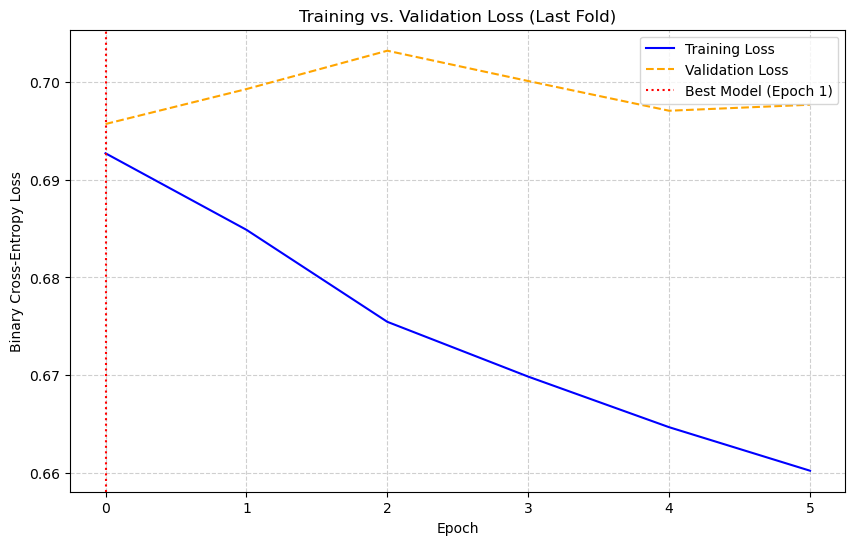

In [69]:
# --- 2. Plot the loss curves ---
if last_history:
    print("\nPlotting loss curves from the last training fold...")
    
    train_loss = last_history['train_loss']
    val_loss = last_history['val_loss']
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Training Loss', color='blue')
    plt.plot(val_loss, label='Validation Loss', color='orange', linestyle='--')
    
    # Find the epoch with the best validation loss
    best_epoch = np.argmin(val_loss)
    plt.axvline(best_epoch, color='red', linestyle=':', 
                label=f'Best Model (Epoch {best_epoch+1})')
    
    plt.title('Training vs. Validation Loss (Last Fold)')
    plt.xlabel('Epoch')
    plt.ylabel('Binary Cross-Entropy Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

else:
    print("No history was captured. Did the training loop run?")

 32, 16, 32, 0.03 droupout rate

In [77]:
# --- 5. Example Usage (using data from previous step) ---
try:
    # --- Run the Evaluation ---
    evaluation_report_torch = evaluate_torch_predictions(
        oos_predictions_torch, 
        all_targets_df, 
        threshold=0.5
    )

    print("\n--- PyTorch Model Evaluation Report ---")
    print(evaluation_report_torch.to_markdown(floatfmt=".4f"))

except NameError:
    print("\n--- Evaluation Script ---")
    print("Please run this script after the PyTorch training script to evaluate")
    print("'oos_predictions_torch' and 'all_targets_df'.")


--- PyTorch Model Evaluation Report ---
| Forecast_Task   |   Accuracy |   Precision |   Recall |   F1-Score |   ROC-AUC |   Num_Samples |   True_Up_Pct |
|:----------------|-----------:|------------:|---------:|-----------:|----------:|--------------:|--------------:|
| Y_DGS10_t+1     |     0.4684 |      0.4375 |   0.1750 |     0.2500 |    0.4654 |       79.0000 |        0.5063 |
| Y_DGS10_t+2     |     0.5696 |      0.7500 |   0.2250 |     0.3462 |    0.5538 |       79.0000 |        0.5063 |
| Y_DGS10_t+3     |     0.5443 |      0.6154 |   0.2051 |     0.3077 |    0.5564 |       79.0000 |        0.4937 |
| Y_DGS10_t+4     |     0.5190 |      0.4667 |   0.1892 |     0.2692 |    0.5103 |       79.0000 |        0.4684 |
| Y_DGS1MO_t+1    |     0.6076 |      0.5333 |   0.2500 |     0.3404 |    0.5931 |       79.0000 |        0.4051 |
| Y_DGS1MO_t+2    |     0.5696 |      0.5385 |   0.2000 |     0.2917 |    0.6195 |       79.0000 |        0.4430 |
| Y_DGS1MO_t+3    |     0.5570 |      0


Plotting loss curves from the last training fold...


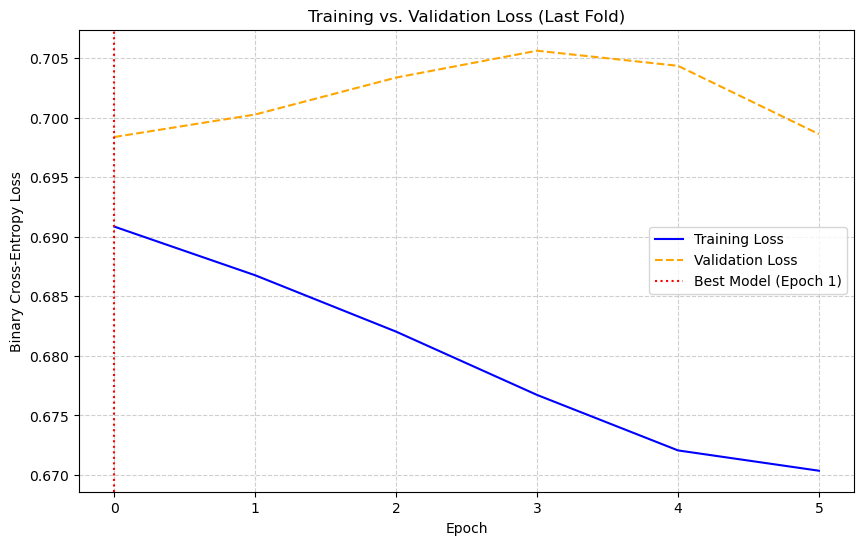

In [78]:
# --- 2. Plot the loss curves ---
if last_history:
    print("\nPlotting loss curves from the last training fold...")
    
    train_loss = last_history['train_loss']
    val_loss = last_history['val_loss']
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Training Loss', color='blue')
    plt.plot(val_loss, label='Validation Loss', color='orange', linestyle='--')
    
    # Find the epoch with the best validation loss
    best_epoch = np.argmin(val_loss)
    plt.axvline(best_epoch, color='red', linestyle=':', 
                label=f'Best Model (Epoch {best_epoch+1})')
    
    plt.title('Training vs. Validation Loss (Last Fold)')
    plt.xlabel('Epoch')
    plt.ylabel('Binary Cross-Entropy Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

else:
    print("No history was captured. Did the training loop run?")